## Variational AutoEncoder - Part 1

In [21]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Normalizing the values to be between 0 and 1 since the values are in gray scales 
# in between 0 and 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
# Reshape the training and testing data to be as an one dimensional array
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


### Network Parameters

In [6]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 15

### Encoder - from image to the latent parameters, decoder, reparametrization trick

In [7]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0821 17:39:55.885266 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 17:39:55.901649 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 17:39:55.902667 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + (K.exp(v) * epsilon)

In [9]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [10]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [11]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [12]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [13]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [14]:
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

### Loss is calculated using reconstruction loss and KL divergence term

In [15]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - (K.square(z_mean) + K.exp(z_log_sigma)), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=total_loss)

W0821 17:39:56.033577 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 17:39:56.049809 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0821 17:39:56.054450 140309307197248 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [17]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decode_intermediate (Dense)  (None, 512)               1536      
_________________________________________________________________
decode_full (Dense)          (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [18]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [19]:
# Fit the model to the data but labels and data would be the same since it is a generative model
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

W0821 17:39:56.330322 140309307197248 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 9s 154us/step - loss: 0.3106 - val_loss: 0.2629
Epoch 2/15
60000/60000 [==============================] - 8s 132us/step - loss: 0.2632 - val_loss: 0.2630
Epoch 3/15
60000/60000 [==============================] - 8s 132us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/15
60000/60000 [==============================] - 8s 133us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 5/15
60000/60000 [==============================] - 8s 130us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 6/15
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 7/15
60000/60000 [==============================] - 8s 140us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 8/15
60000/60000 [==============================] - 8s 134us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 9/15
60000/60000 [==============================] - 9s 142us/step - loss: 0.2630 - val_loss: 0.2

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [30]:
x_test_encoded.shape

(10000, 2)

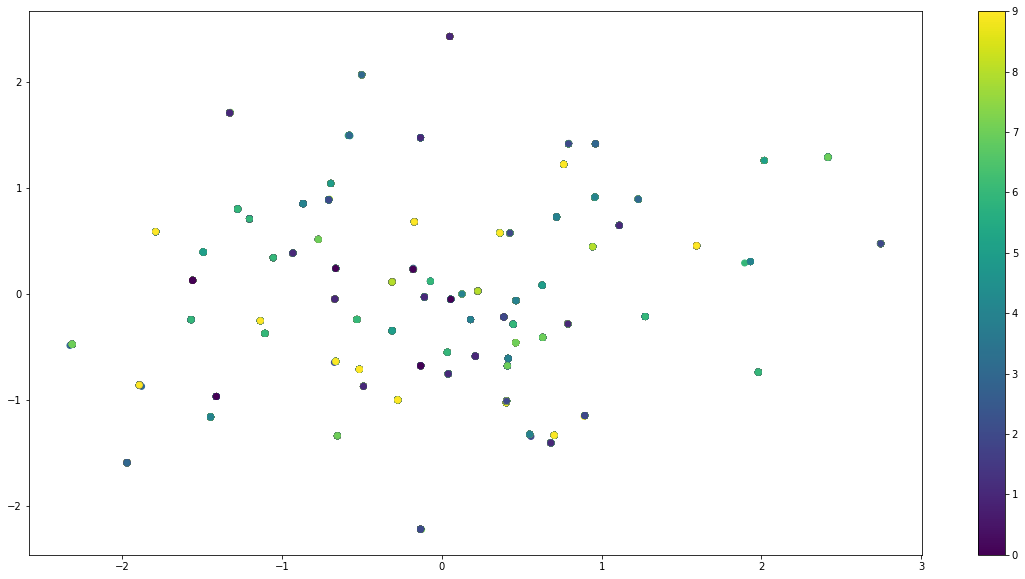

In [34]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()